# Program Description: Data Reconciliation (Module 3)
## Overview:
This module performs data reconciliation for the results obtained from **Module 1** (XAS Simulation). The purpose is to apply interpolation and data preprocessing to the features `['chi', 'xmu', 'rdf']` obtained from these modules. The module ensures that the features are aligned, resampled, and interpolated as necessary for consistent comparison and further analysis.

## Input Files:
- **Input Features (before interpolation)**: 
  - **Features**: `['chi', 'xmu', 'rdf']`
  - **Description**: These are the raw features (chi, xmu, rdf) obtained from **Module 1** and **Module 2**.
  - **Format**: CSV or data files containing the raw feature data.

## Output Files:
- **Output Features (after interpolation)**: 
  - **Features**: `['chi', 'xmu', 'rdf']`
  - **Description**: These are the features that have undergone interpolation and preprocessing.
  - **Format**: CSV or data files containing the interpolated feature data.
  
The features are saved with new interpolated values that align across the samples, making the data consistent and ready for further analysis or visualization.

## Process:
1. **Interpolation**: 
   - The module applies interpolation techniques to the features `['chi', 'xmu', 'rdf']` to ensure that data points across the samples are consistently aligned. This allows for comparisons between features that were calculated with different resolutions or sample frequencies.
   - Interpolation methods such as linear interpolation, cubic spline, or other relevant techniques are used depending on the data requirements.

2. **Data Alignment**: 
   - Ensures that the features from both modules are aligned in terms of sample points (k-values, energy, or other relevant metrics), and missing or unaligned data is handled through the interpolation process.

3. **Output Data**: 
   - After the interpolation is applied, the processed data is saved to new files with updated feature values, allowing users to continue their analysis with the reconciled and consistent data.

## Example Workflow:
1. **Input**: Raw `['chi', 'xmu', 'rdf']` from **Module 1** (XAS Simulation) and **Module 2** (Structure Descriptors).
2. **Process**: Interpolate data, reconcile features, and ensure consistency across the samples.
3. **Output**: Interpolated `['chi', 'xmu', 'rdf']`, saved in a specified directory.

## Notes:
- This module is especially useful when the data from **Module 1**  are not directly comparable due to varying resolutions or inconsistencies in sampling points. The interpolation process reconciles the differences to ensure uniformity across the dataset.
- The interpolated data is stored in the same file format as the input data, making it easy to access and further process.


# Import libraries

In [1]:
import os
from os.path import join, splitext, split,basename
import sys 
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from larch import Group
from larch.xafs import pre_edge
import math
import shutil


# Version Information

In [2]:
def get_python_version():
    return sys.version
def get_package_version(package_name):
    try:
        module = __import__(package_name)
        version = getattr(module, '__version__', None)
        if version:
            return version
        else:
            return pkg_resources.get_distribution(package_name).version
    except (ImportError, AttributeError, pkg_resources.DistributionNotFound):
        return "Version info not found"

packages = ['pandas', 'numpy', 'sklearn', 'larch']
for package in packages:
    print(f"{package}: {get_package_version(package)}")
print(f"Python: {get_python_version()}")

pandas: 2.0.3
numpy: 1.23.5
sklearn: 1.3.2
larch: 0.9.76
Python: 3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:46:39) 
[GCC 10.4.0]


# Parameter Settings

## Input Files:
- **`load_path`**: 
  - **Description**: Specifies the directory path where the dataset files are stored.
  - **Usage**: Ensure this path points to the folder containing the data to be used for further processing.
  - **Example**: `"/media/dell-hd/data1/datasets/Au-datasets"`

## Data Types:
- **`features`**: 
  - **Description**: A list of features to be used for processing.
  - **Usage**: Defines the types of data (such as chi, xmu, rdf) that will be analyzed.
  - **Example**: `['chi', 'xmu', 'rdf']`

## Label Types:
- **`labels`**: 
  - **Description**: Defines the types of labels to be used in the analysis. 
  - **Usage**: Customize based on the specific labels you want to  analyze.

## Directory Checks:
- **`load_path` existence check**: 
  - **Description**: Verifies that the specified `load_path` exists before proceeding with further operations.
  - **Usage**: Raises an error if the path does not exist, ensuring that the user has provided a valid directory.

## Output Paths:
- **`save_data_path`**: 
  - **Description**: Directory path where the final processed data will be saved.
  - **Usage**: This path stores the datasets generated by the method and analysis.
  - **Example**: `os.path.join(load_path, f"datasets({method})")`

In [3]:
# Define the method and load path for the dataset
load_path = "0926-datasets"
# Define the feature types to be used in the analysis (e.g., chi, xmu, rdf)
features = ['chi', 'xmu', 'rdf']
# Define label types
label_types = ["cn", "cr"]
n=5001
# Check if the specified load path exists
if os.path.exists(load_path):
    print(f"File '{load_path}' exists.")  # Print a message if the path exists
else:
    raise FileNotFoundError(f"File '{load_path}' does not exist.")  # Raise an error if the path does not exist

# Create a save path for the processed data, appending the method name to the dataset path
#save_data_path = os.path.join(load_path, "datasets")
for data_type in features:
    globals()[f"{data_type}_path"] = join(load_path, data_type)
# Create a dictionary to store paths, showing only common directory paths
prepare_path = os.path.join(load_path, f"prepare")
for data_type in features:
    globals()[f"save_{data_type}_path"] = join(prepare_path, data_type)
# Check and create necessary directories
paths_to_check = [prepare_path] + [globals()[f'save_{data_type}_path'] for data_type in features]
for path in paths_to_check:
    if not os.path.exists(path):
        os.makedirs(path)



File '0926-datasets' exists.


In [4]:
# Function to read chi data from CSV files, optionally save and plot the data
def get_chi(path, n=-1, save_path=False, plot=False):
    plot_dat = None
    chi = []
    # Sort CSV files by filename (assuming filenames are numerical) and limit to 'n' files
    file_list = sorted(glob.glob(join(path, "*.csv")), key=lambda x: int(splitext(basename(x))[0]))[:n]
    
    for file in file_list:
        index = int(splitext(basename(file))[0])
        dat = pd.read_csv(file)
        
        # Save the data to the specified path if 'save_path' is set to True
        if save_path:
            dat.to_csv(join(save_path, basename(file)), index=False)
        
        # If the file index matches the 'plot' value, store the data for plotting
        if index == plot:
            plot_dat = dat
        
        # Remove the first row if it corresponds to a chi value of 0
        if dat.k[0] == 0:
            dat = dat[1:]
        
        chi.append((index, dat.chi.values))
    
    # Sort chi data by index and extract the chi values
    chi.sort(key=lambda x: x[0])
    chi = [x[1] for x in chi]
    
    # If 'plot' is specified, plot the chi data for the chosen sample
    if plot:
        fig, ax = plt.subplots(1, 1)
        ax.plot(plot_dat.k, plot_dat.chi * (plot_dat.k ** 2))  # Chi*k^2 plot
        plt.show()
    
    return np.array(chi)
# Function to read xmu data, perform pre-edge correction, and return the processed data
def get_xmu(path, n=-1, save_path=False, plot=False):
    plot_dat = None
    plot_dat_new = None
    emin, emax = float('inf'), float('-inf')
    
    # Sort CSV files and limit to 'n' files
    file_list = sorted(glob.glob(join(path, "*.csv")), key=lambda x: int(splitext(basename(x))[0]))[:n]
    
    for file in file_list:
        index = int(splitext(basename(file))[0])
        dat = pd.read_csv(file)
        
        # Store the data for plotting if 'plot' matches the current index
        if index == plot:
            plot_dat = dat
        
        dat = Group(energy=dat.energy, mu=dat.mu)
        pre_edge(dat)  # Perform pre-edge correction
        emin = min(emin, dat.e0)
        emax = max(emax, dat.e0)
    
    # Interpolate the data to a uniform energy grid
    xmu = []
    xvals = np.linspace(emin - 10, emax + 200, 1000)
    
    for file in file_list:
        index = int(splitext(basename(file))[0])
        dat = pd.read_csv(file)
        yvals = np.interp(xvals, dat.energy, dat.mu)
        
        # Store the interpolated data for plotting
        if index == plot:
            plot_dat_new = (xvals, yvals)
        
        xmu.append((index, yvals))
    
    # Sort xmu data by index and extract the y-values
    xmu.sort(key=lambda x: x[0])
    xmu = [x[1] for x in xmu]
    
    # Plot the original and interpolated xmu data if 'plot' is set
    if plot and plot_dat_new is not None:
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        plt.plot(plot_dat.energy, plot_dat.mu)  # Original data
        plt.subplot(1, 2, 2)
        plt.plot(plot_dat_new[0], plot_dat_new[1])  # Interpolated data
        plt.show()
    
    # Save the processed xmu data to CSV files if 'save_path' is specified
    if save_path:
        for i, file in enumerate(file_list):
            dat = pd.DataFrame({"energy": xvals, "mu": xmu[i]})
            dat.to_csv(join(save_path, basename(file)), index=False)
    
    return xmu

# Function to read norm spectrum data, perform pre-edge correction, and return the processed data
def get_norm(path, n=-1, save_path=False, plot=False):
    plot_dat = None
    plot_dat_new = None
    emin, emax = float('inf'), float('-inf')
    
    # Sort CSV files and limit to 'n' files
    file_list = sorted(glob.glob(join(path, "*.csv")), key=lambda x: int(splitext(basename(x))[0]))[:n]
    
    for file in file_list:
        index = int(splitext(basename(file))[0])
        dat = pd.read_csv(file)
        
        # Store the data for plotting if 'plot' matches the current index
        if index == plot:
            plot_dat = dat
        
        dat = Group(energy=dat.energy, mu=dat.norm)
        pre_edge(dat)  # Perform pre-edge correction
        emin = min(emin, dat.e0)
        emax = max(emax, dat.e0)
    
    # Interpolate the data to a uniform energy grid
    norm = []
    xvals = np.linspace(emin - 30, emax + 400, 500)
    
    for file in file_list:
        index = int(splitext(basename(file))[0])
        dat = pd.read_csv(file)
        yvals = np.interp(xvals, dat.energy, dat.norm)
        
        # Store the interpolated data for plotting
        if index == plot:
            plot_dat_new = (xvals, yvals)
        
        norm.append((index, yvals))
    
    # Sort norm data by index and extract the y-values
    norm.sort(key=lambda x: x[0])
    norm = [x[1] for x in norm]
    
    # Plot the original and interpolated norm data if 'plot' is set
    if plot and plot_dat_new is not None:
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        plt.plot(plot_dat.energy, plot_dat.norm)  # Original data
        plt.subplot(1, 2, 2)
        plt.plot(plot_dat_new[0], plot_dat_new[1])  # Interpolated data
        plt.show()
    
    # Save the processed norm data to CSV files if 'save_path' is specified
    if save_path:
        for i, file in enumerate(file_list):
            dat = pd.DataFrame({"energy": xvals, "norm": norm[i]})
            dat.to_csv(join(save_path, basename(file)), index=False)
    
    return norm

# Function to read RDF (Radial Distribution Function) data and return the processed data
def get_rdf(path, n=-1, save_path=False, plot=False):
    plot_dat = None
    rdf = []
    
    # Sort CSV files and limit to 'n' files
    file_list = sorted(glob.glob(join(path, "*.csv")), key=lambda x: int(splitext(basename(x))[0]))[:n]
    
    for file in file_list:
        index = int(splitext(basename(file))[0])
        dat = pd.read_csv(file)
        
        # Save the data to the specified path if 'save_path' is set
        if save_path:
            dat.to_csv(join(save_path, basename(file)), index=False)
        
        # Store the data for plotting if 'plot' matches the current index
        if index == plot:
            plot_dat = dat
        
        rdf.append((index, dat['g(r)'].values))
    
    # Sort RDF data by index and extract the g(r) values
    rdf.sort(key=lambda x: x[0])
    rdf = [x[1] for x in rdf]
    
    # Plot the RDF data if 'plot' is set
    if plot and plot_dat is not None:
        plt.figure(figsize=(10, 6))
        plt.plot(plot_dat['r'], plot_dat['g(r)'])  # RDF plot
        plt.xlabel("r")
        plt.ylabel("g(r)")
        plt.title("RDF Plot")
        plt.show()
    
    return np.array(rdf)
#Function to read wavelet change data
def get_wt(path, rate=1200, n=40, save_path=False, plot=False):
    if save_path:
        save_path1, save_path2 = join(save_path, "1"), join(save_path, "2")
        if not os.path.exists(save_path1):
            os.makedirs(save_path1)
        if not os.path.exists(save_path2):
            os.makedirs(save_path2)
    file_list = sorted(glob.glob(join(path, "*.csv")), key=lambda x: int(splitext(basename(x))[0]))[:n]
    dat = pd.read_csv(file_list[0])
    k_list, r_list = sorted(list(set(dat.k.values))), sorted(list(set(dat.r.values)))
    if 0 in k_list:
        k_list.remove(0.0)
    k_list, r_list = k_list[::math.ceil(len(k_list)/40)], r_list[::math.ceil(len(r_list)/40)]
    
    wt = np.array([])
    all_dat = []
    for file in file_list:
        index = int(splitext(basename(file))[0])
        dat = pd.read_csv(file)
        dat = dat[dat['k'].isin(k_list)]
        dat = dat[dat['r'].isin(r_list)]
        dat.index = range(len(dat))
        all_dat.append(dat)
        
        if save_path1:
            dat.to_csv(join(save_path1, basename(file)), index=False)
        if len(wt) == 0:
            wt = dat.mag.values.reshape(1, -1)
        else:
            wt = np.concatenate((wt, dat.mag.values.reshape(1, -1)), axis=0)
    
    var = np.var(wt, axis=0)
    index_list = np.where(var > sorted(var, reverse=True)[rate])[0]
    index_list_ = np.where(var <= sorted(var, reverse=True)[rate])[0]
    new_wt = wt[:, index_list]
    
    if plot:
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        x, y = np.meshgrid(k_list, r_list)
        z = wt[plot, :].reshape((33, 40))
        plt.contourf(x, y, z, cmap=plt.cm.bwr, levels=40)
        plt.xlabel(r'Wavenumber k $(\AA^{-1})$', fontsize=15)
        plt.ylabel(r'Radial distance R $(\AA^{-1})$', fontsize=12)
        plt.title("Wavelet Transform: Magnitude", fontsize=15)
        
        plt.subplot(1, 2, 2)
        x, y = np.meshgrid(k_list, r_list)
        z = wt[plot, :]
        z[[index_list_]] = 0
        z = z.reshape((33, 40))
        plt.contourf(x, y, z, cmap=plt.cm.bwr, levels=40)
        plt.xlabel(r'Wavenumber k $(\AA^{-1})$', fontsize=15)
        plt.ylabel(r'Radial distance R $(\AA^{-1})$', fontsize=12)
        plt.title("Wavelet Transform: Magnitude", fontsize=15)
        
        plt.show()
    if save_path2:
        for file, dat in zip(file_list, all_dat):
            dat = dat.loc[index_list, :]
            dat.index = range(len(dat))
            dat.to_csv(join(save_path2, basename(file)), index=False)
    return new_wt

#   Main program

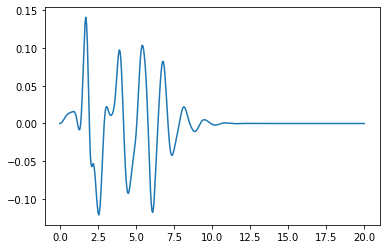

fature_chi finished


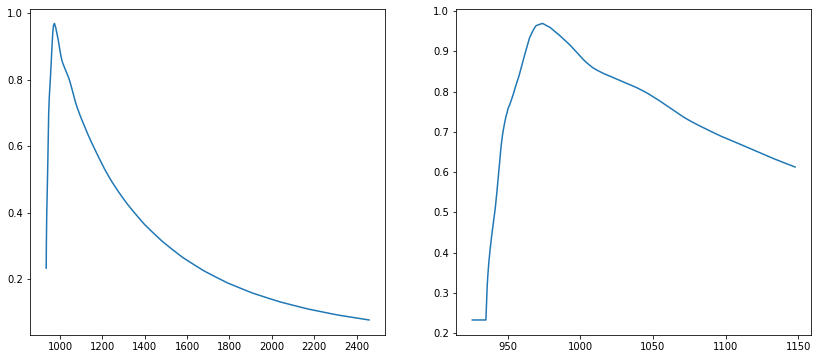

fature_xmu finished


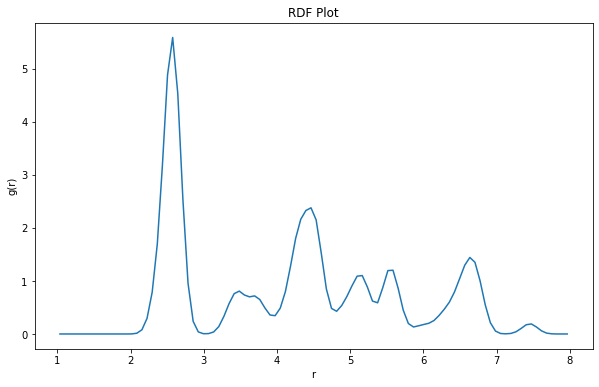

fature_rdf finished


In [5]:
def process_data(features,n):
    if 'chi' in features:
        chi = get_chi(chi_path, save_path=save_chi_path, n=n, plot=1)
        print(f"fature_chi finished")
    if 'xmu' in features:
        xmu = get_xmu(xmu_path, save_path=save_xmu_path, n=n, plot=1)
        print(f"fature_xmu finished")
    if 'norm' in features:
        norm = get_norm(norm_path, save_path=save_norm_path, n=n, plot=1)
        print(f"fature_norm finished")
    if 'rdf' in features:
        rdf = get_rdf(rdf_path, save_path=save_rdf_path, n=n, plot=1)
        print(f"fature_rdf finished")
    if 'wt' in features:
        wt = get_wt(wt_path, n=n, save_path=save_wt_path, rate=150, plot=1)
        print(f"fature_wt finished")
process_data(features, n)


In [6]:
for label_type in label_types:
    label_path = os.path.join(load_path, label_type)
    target_folder = os.path.join(prepare_path, label_type)
    os.makedirs(target_folder, exist_ok=True)
    if os.path.exists(label_path):  
        for item in os.listdir(label_path):
            source_item = os.path.join(label_path, item)
            destination_item = os.path.join(target_folder, item)

            if os.path.isdir(source_item):
                shutil.copytree(source_item, destination_item, dirs_exist_ok=True)
            else:
                shutil.copy2(source_item, destination_item)

print("All label files have been copied to the 'prepare' subfolders successfully. ✅")

All label files have been copied to the 'prepare' subfolders successfully. ✅
